# [2b] OpenCVスタートアップ課題+フレームワークを使わない深層学習課題(続き)

## 6.OpenCVで顔認識・顔検出を行う

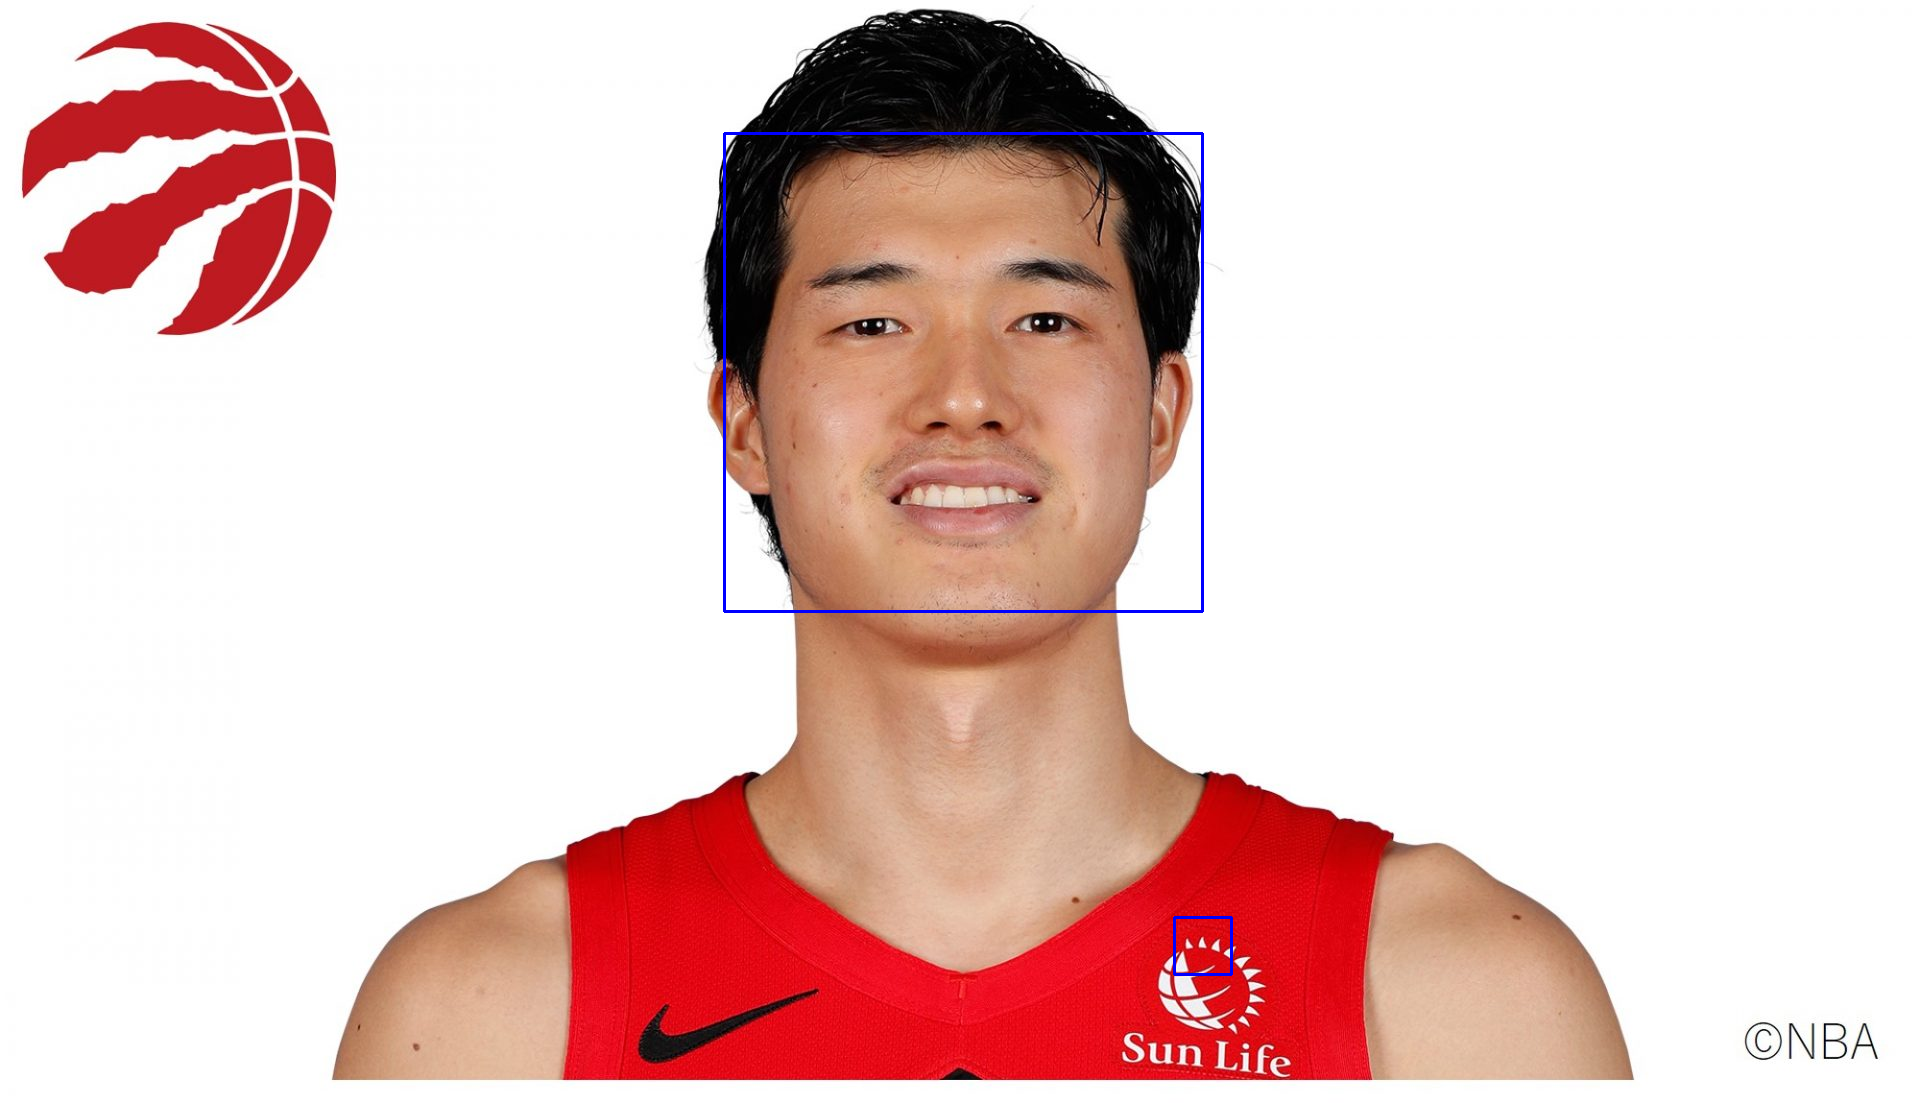

In [1]:
import cv2, matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image, display
# imshow()メソッドで，画像を簡便に呼び出せるようにする
def imshow(img):
    '''画像を Notebook 上にインラインで表示する。
    '''
    img = cv2.imencode('.png', img)[1]
    display(Image(img))

# カスケード分類器
# 分類器の情報が記載された設定ファイルを読み込んで作成します
# OpenCV では、顔や目を検出するための設定ァイルが用意されています
classifier = cv2.CascadeClassifier("./xml/haarcascade_frontalface_default.xml")

img = cv2.imread("./img/watanabe18.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

targets = classifier.detectMultiScale(gray)

for x, y, w, h in targets:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

imshow(img)

## 7.領域分割
### OpenCVのサンプルコードを参考にして，次の４通りを試してみてください．<br>
<li>1.k-means法(1-1.色のみ, 1-2.色+座標),<li>3.meanshift(PyrMeanShiftFiltering),<li>4.watershed

### 1.k-means法(色のみ)

下記ページの3.Color Quantizationを参考<br>
https://docs.opencv.org/4.x/d1/d5c/tutorial_py_kmeans_opencv.html

日本語訳として下記を参考<br>
http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html#opencvk-means

#### 3. 色の量子化

色の量子化とは、画像の色数を減らす処理のことです。その理由のひとつに、メモリの削減があります。また、機器によっては、限られた色数しか出せないという制約がある場合があります。そのような場合にも、色量子化は行われます。ここでは、k-meansクラスタリングを用いて、色量子化を行います。<br>
<br>
特に新しい説明はありません。特徴量は3つ、例えばR、G、Bです。そこで、画像をM×3の大きさの配列に整形する必要があります（Mは画像の画素数）。そして、クラスタリングの後、セントロイドの値（これもR,G,B）をすべてのピクセルに適用し、結果として指定された色数の画像となるようにするのです。そして、再び元の画像の形状に戻す必要があります。以下はそのコードです。<br>

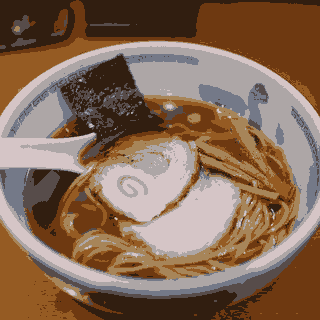

In [2]:
import cv2, matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image, display
# imshow()メソッドで，画像を簡便に呼び出せるようにする
def imshow(img):
    '''画像を Notebook 上にインラインで表示する。
    '''
    img = cv2.imencode('.png', img)[1]
    display(Image(img))


img = cv2.imread("./img/ramen.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# ndarray(y,x,[B,G,R])を変形(y * x,[B,G,R])
Z = img.reshape((-1,3))
# print(img.shape) #(320, 320, 3)
# print(Z.shape) #(102400, 3)

# float32に型変換
Z = np.float32(Z)

# 計算終了条件の設定。指定された精度(1.0)か指定された回数(10)計算したら終了
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# クラスター数
K = 8

# K-Meansクラスタリングの実施
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

#         ret : 各点と対応する重心の距離の二乗和．
#         labels : 各要素に与えられたラベル(‘0’, ‘1’ …)のarray (前チュートリアルにおける ‘code’ )．
#         centers : クラスタの重心のarray．

# print("ret: ",ret) # 64686665.26619017
# print("label: ",label) # [1]-[8]
# print("center: ",center) # 8個のRGB配列

# 各クラスタの中心色リストcenterをunit8に型変換
center = np.uint8(center)
# 中心色リストcenterから分類結果labelの要素を取り出す
res = center[label.flatten()]
# 元画像の形状に変形
k_img = res.reshape((img.shape))

imshow(k_img)

## 1-2.k-means法(1-2.色+座標)

色と座標という点を勘案して，XY平面上のデータを用いて検討する．

参考にしたのは，下記ページの「２．複数の特徴を持つデータ」です．<br>
http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html#opencvk-means

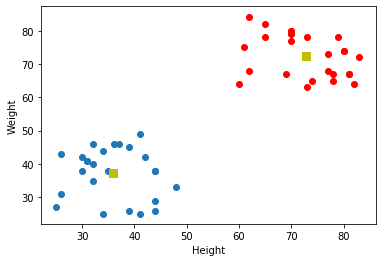

In [3]:
# random.randint(low, high=None, size=None, dtype=int)
X = np.random.randint(25,50,(25,2))
Y = np.random.randint(60,85,(25,2))
Z = np.vstack((X,Y)) # 縦方向に配列を連結

# np.float32に方変換
Z = np.float32(Z)

# criteria : 繰り返し処理の終了条件
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

#         ret : 各点と対応する重心の距離の二乗和．
#         labels : 各要素に与えられたラベル(‘0’, ‘1’ …)のarray (前チュートリアルにおける ‘code’ )．
#         centers : クラスタの重心のarray．
ret,label,center=cv2.kmeans(Z,2,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Now separate the data, Note the flatten()
# ravel関数を適用させると、一次元のリストが返却
# labelが0,1のものを抽出
A = Z[label.ravel()==0]
B = Z[label.ravel()==1]
# print(A, B)

# Plot the data
plt.scatter(A[:,0],A[:,1])
plt.scatter(B[:,0],B[:,1],c = 'r')
plt.scatter(center[:,0],center[:,1],s = 80,c = 'y', marker = 's')
plt.xlabel('Height'),plt.ylabel('Weight')
plt.show()

## 7.領域分割
## 7-3.meanshift(PyrMeanShiftFiltering)

以下，OpenCVの<a href="http://opencv.jp/opencv-2.2/py/imgproc_miscellaneous_image_transformations.html?highlight=pyrmeanshiftfiltering#PyrMeanShiftFiltering">ドキュメント</a>から摘記した．

PyrMeanShiftFiltering(src, dst, sp, sr, max_level=1, termcrit=(CV_TERMCRIT_ITER+CV_TERMCRIT_EPS, 5, 1)) → None

    Mean-Shift法による画像セグメンテーションを行います．
    パラメタ:	

        src (CvArr) – 入力画像．8ビット，3チャンネル．
        dst (CvArr) – 出力画像．入力が像と同じフォーマット，同じサイズ．
        sp (float) – 空間窓の半径．
        sr (float) – 色空間窓の半径．
        max_level (int) – セグメンテーションに用いるピラミッドの最大レベル．
        termcrit (CvTermCriteria) – 終了条件：Mean-Shiftの反復をいつ止めるかを表します．

実装例：<br>
https://algorithm.joho.info/programming/python/opencv-anime/

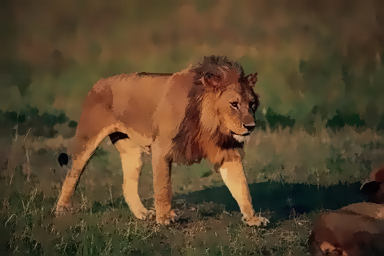

In [4]:
img = cv2.imread("./img/lion.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = cv2.pyrMeanShiftFiltering(img, 5, 20) # 減色化
#img = cv2.pyrMeanShiftFiltering(img, 10, 40) # より減色化
imshow(img)

## 7.領域分割
## 7-4.watershed(分水嶺)アルゴリズム
接触しているものを分離するアルゴリズム．<br>
OpenCVはマーカベースのwatershedアルゴを実装．事前に次の２つの作業が必要．
<li>オブジェクトそれぞれに異なるラベルを与える</li>
<li>何もわからない領域には0でラベルを与える</li>

watershedアルゴ適用後は，マーカは与えたラベルで更新され，オブジェクトの境界は-1の値

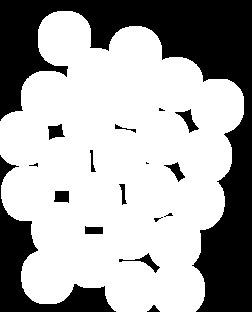

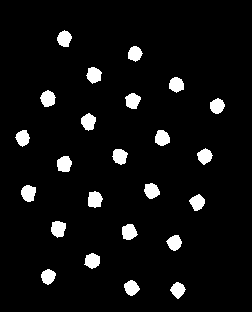

In [5]:
img = cv2.imread("./img/water_coins.jpg", cv2.IMREAD_COLOR)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 閾値処理
ret,thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# オープニング処理（収縮と膨張）で，ノイズ除去
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# 膨張処理で確かな背景領域を取得
sure_background = cv2.dilate(opening, kernel, iterations=3)

# 確かな前景領域を取得
# 前景（非０要素）から最も近い背景（０要素）までの距離を計算
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

# 背景までの距離が遠い要素を前景領域として取得
ret, sure_foreground = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# imshow(sure_foreground)

# 未知の領域（前景でも背景でもない領域）を取得
sure_foreground = np.uint8(sure_foreground)
unknown = cv2.subtract(sure_background, sure_foreground)

# 可視化
imshow(sure_background)
imshow(sure_foreground)

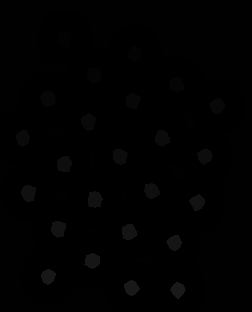

In [6]:
# 背景に０，前景に１以上のラベル付を実施
ret, markers = cv2.connectedComponents(sure_foreground)
# watershedアルゴリズムはラベル０を未知の領域とみなすため，
# 背景のラベルを０ではなく，１にするため全ての要素に１を加算
markers = markers+1

# 未知の領域に０のラベル付を実施
markers[unknown == 255] = 0


imshow(markers)

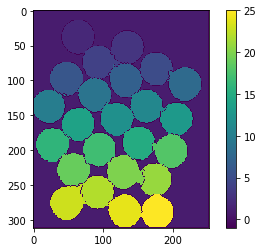

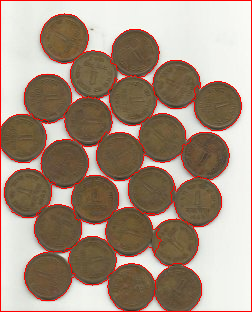

In [7]:
# watershedアルゴにて領域分割
markers = cv2.watershed(img,markers)

# グラフの可視化
plt.imshow(markers)
plt.colorbar()
plt.show()

# 描画した結果
img[markers == -1] = [0,0,255] #BGR
imshow(img)

## 8.ポアソンブレンディング
画像合成についても勉強してみましょう． GANが流行っていますが，2枚の画像の合成ならCGの手法の方が きれいにできます．GANで物体を生成して，背景はこの手法で合成することもできます．もしくは，物体画像と背景画像を 自由に組み合わせて，深層学習の，特にobject detection 用の 学習データ生成にも使えるでしょう． なお，Seamless-cloningは，Poisson blending の別名です．

(379, 243, 3)
(536, 750, 3)


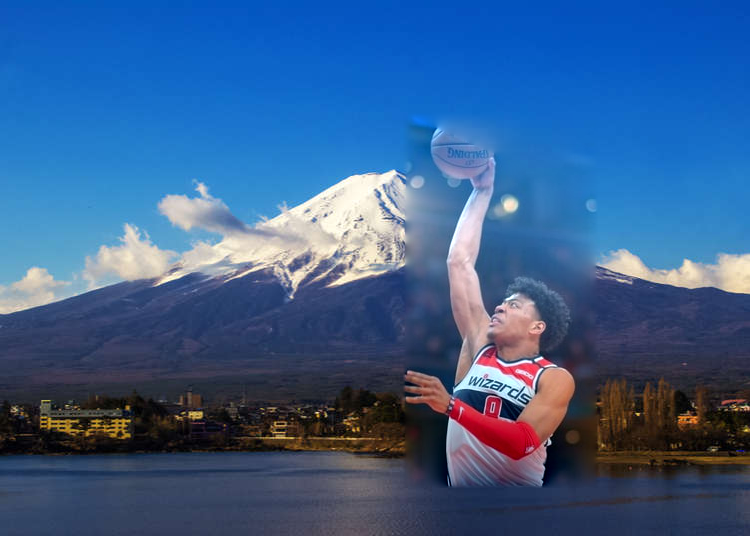

In [8]:
# Standard imports
import cv2, matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image, display
# imshow()メソッドで，画像を簡便に呼び出せるようにする
def imshow(img):
    '''画像を Notebook 上にインラインで表示する。
    '''
    img = cv2.imencode('.png', img)[1]
    display(Image(img))

# Read images
src = cv2.imread("./img/poisson/rui.jpg")
print(src.shape)
dst = cv2.imread("./img/poisson/fuji.jpg")
print(dst.shape)

# Create a rough mask around the airplane.
src_mask = np.zeros(src.shape, src.dtype)
# poly = np.array([ [4,80], [30,54], [151,63], [254,37], [298,90], [272,134], [43,122] ], np.int32)
poly = np.array([ [4,80], [10,0], [151,63], [200,0], [200,100], [200,379], [4,379] ], np.int32)


cv2.fillPoly(src_mask, [poly], (255, 255, 255))

# This is where the CENTER of the airplane will be placed
center = (500,300)

# Clone seamlessly.
output = cv2.seamlessClone(src, dst, src_mask, center, cv2.NORMAL_CLONE)

# Save result
# cv2.imwrite("./img/poisson/dunk.jpg", output)
out = cv2.imread("./img/poisson/dunk.jpg")

imshow(output)

### Normal Cloning Result
### Mixed Cloning Result

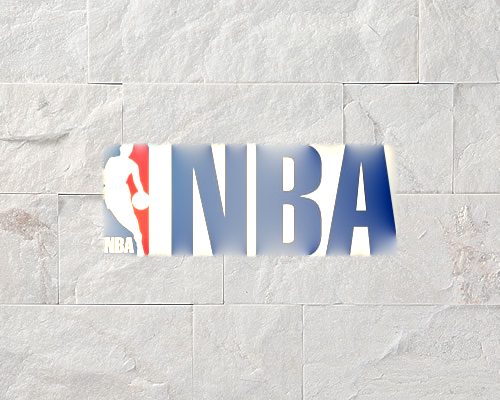

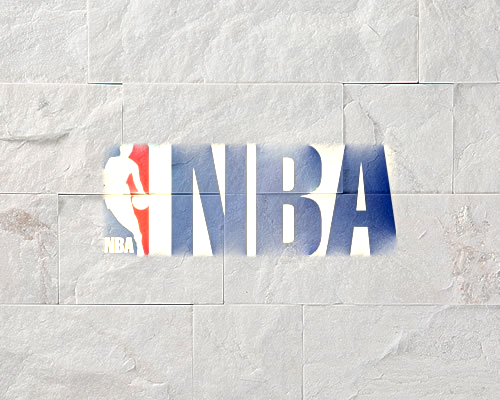

True

In [9]:
import cv2, matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import Image, display
# imshow()メソッドで，画像を簡便に呼び出せるようにする
def imshow(img):
    '''画像を Notebook 上にインラインで表示する。
    '''
    img = cv2.imencode('.png', img)[1]
    display(Image(img))

# Read images : src image will be cloned into dst
im = cv2.imread("./img/poisson/whitestone.jpg", cv2.IMREAD_COLOR)
obj= cv2.imread("./img/poisson/logo.jpg", cv2.IMREAD_COLOR)
# print(im.shape)
# print(obj.shape)

# Create an all white mask
mask = 255 * np.ones(obj.shape, obj.dtype)
#print(mask)

# dstにおけるsrcの中心位置
width, height, channels = im.shape
center = (height//2, width//2) # CAUTION!!: center should be INT
# print(center)

# src を dst にシームレスに複製し、その結果を出力
# center should be INT!! It means argument of 'p'
normal_clone = cv2.seamlessClone(obj, im, mask, center, cv2.NORMAL_CLONE)
mixed_clone = cv2.seamlessClone(obj, im, mask, center, cv2.MIXED_CLONE)

imshow(normal_clone)
imshow(mixed_clone)

# Write results
cv2.imwrite("./img/poisson/normal-clone.jpg", normal_clone)
cv2.imwrite("./img/poisson/mixed-clone.jpg", mixed_clone)
